In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('PaySim_Dataset.csv')

In [ ]:
print("Fraud Distribution:")
print(df['isFraud'].value_counts())
print("\n" + "="*30 + "\n")

# Find out which transaction types contain fraud
print("Fraud by Transaction Type:")
print(df.groupby('type')['isFraud'].sum())

Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


Fraud by Transaction Type:
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


In [ ]:
df_focused = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])].copy()

print(f"Original DataFrame shape: {df.shape}")
print(f"Focused DataFrame shape: {df_focused.shape}")

Original DataFrame shape: (6362620, 11)
Focused DataFrame shape: (2770409, 11)


In [ ]:
# --- Feature Group 1: Sender Balance Logic ---
df_focused['senderBalanceError'] = df_focused['oldbalanceOrg'] + df_focused['amount'] - df_focused['newbalanceOrig']

# ADD THIS LINE: This is the missing feature
df_focused['isOrigAccountEmpty'] = (df_focused['newbalanceOrig'] == 0).astype(int)


# --- Feature Group 2: Advanced Time-Based Features ---
df_focused['hour_of_day'] = df_focused['step'] % 24
df_focused['day_of_week'] = (df_focused['step'] // 24) % 7


# Display the first few rows with the new features
print("DataFrame with new Time-Based and Error features:")
# Add the new column to the print statement to verify
print(df_focused[['step', 'hour_of_day', 'day_of_week', 'senderBalanceError','isOrigAccountEmpty']].head())

DataFrame with new Time-Based and Error features:
    step  hour_of_day  day_of_week  senderBalanceError  isOrigAccountEmpty
2      1            1            0              362.00                   1
3      1            1            0              362.00                   1
15     1            1            0           244458.94                   1
19     1            1            0           216015.30                   1
24     1            1            0           322520.89                   1


In [ ]:
# --- Feature Group 3 & 4: Behavioral and Velocity ---

# Sort by user and time to calculate time-based velocity correctly
df_focused.sort_values(by=['nameOrig', 'step'], inplace=True)

# Calculate historical average amount for each user
user_avg_amount = df_focused.groupby('nameOrig')['amount'].transform('mean')
df_focused['amount_deviation_from_avg'] = df_focused['amount'] - user_avg_amount

# Calculate time since last transaction for each user
time_since_last_tx = df_focused.groupby('nameOrig')['step'].diff().fillna(0) # fillna(0) for firsttransaction
df_focused['time_since_last_transaction'] = time_since_last_tx

# --- For 'is_new_recipient', we need a way to track seen pairs ---
# This is a simplified but effective way to do it
# It checks if this is the first time we see this sender-recipient pair
# CORRECTED LINE: Added a comma after the subset list
df_focused['is_new_recipient'] = (~df_focused.duplicated(subset=['nameOrig', 'nameDest'],keep='first')).astype(int)


# Display the first few rows with these final features
print("DataFrame with final Behavioral and Velocity features:")
# We show a sample from the middle of the dataframe to see more representative values
print(df_focused[[
          'nameOrig',
          'step',
          'amount',
          'amount_deviation_from_avg',
          'time_since_last_transaction',
          'is_new_recipient'
]].head(10))

DataFrame with final Behavioral and Velocity features:
            nameOrig  step      amount  amount_deviation_from_avg  \
3196942  C1000000639   249   244486.46                        0.0   
4548211  C1000004053   327   211189.64                        0.0   
847860   C1000004530    41    93865.13                        0.0   
2825292  C1000005353   226  3228390.11                        0.0   
2202461  C1000005555   185   233109.79                        0.0   
5502195  C1000005749   380  3229333.12                        0.0   
4275204  C1000008236   307   673726.47                        0.0   
3789087  C1000008393   280    58347.84                        0.0   
492522   C1000008582    20   315626.96                        0.0   
1336760  C1000008975   137    29144.26                        0.0   

         time_since_last_transaction  is_new_recipient  
3196942                          0.0                 1  
4548211                          0.0                 1  
847860        

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# --- Define our final feature set ---
# Note: We are NOT using recipient balance/name data
final_features = [
          'amount',
          'isOrigAccountEmpty', # This is still a useful feature we engineered
          'senderBalanceError',
          'hour_of_day',
          'day_of_week',
          'amount_deviation_from_avg',
          'is_new_recipient',
          'time_since_last_transaction',
          'type_CASH_OUT', # We still need to one-hot encode the type
          'type_TRANSFER'
]

# One-hot encode transaction type
df_focused['type_CASH_OUT'] = (df_focused['type'] == 'CASH_OUT').astype(int)
df_focused['type_TRANSFER'] = (df_focused['type'] == 'TRANSFER').astype(int)


# --- Create Final X and y ---
X_final = df_focused[final_features]
y_final = df_focused['isFraud']


# --- Train-Test Split ---
# We stratify on y_final to ensure fraud cases are distributed properly
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42, stratify=y_final)


# --- Train the Final XGBoost Model ---
print("--- Training Final, Advanced XGBoost Model ---")
# Calculate the scale_pos_weight for the imbalanced data
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

final_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, scale_pos_weight=ratio)

# Train the model
final_model.fit(X_train, y_train)


# --- Evaluate the Final Model ---
print("\n--- Final Model Evaluation ---")
y_pred_final = final_model.predict(X_test)

print("\nClassification Report for Final Model:")
print(classification_report(y_test, y_pred_final, target_names=['Not Fraud', 'Fraud']))

--- Training Final, Advanced XGBoost Model ---

--- Final Model Evaluation ---

Classification Report for Final Model:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    828659
       Fraud       0.27      0.99      0.43      2464

    accuracy                           0.99    831123
   macro avg       0.64      0.99      0.71    831123
weighted avg       1.00      0.99      0.99    831123



In [ ]:
# Feature 1: Does the transaction empty the sender's account?
df_focused['isOrigAccountEmpty'] = (df_focused['oldbalanceOrg'] - df_focused['amount'] == 0).astype(int)

# Feature 2: Is the recipient's account new (had zero balance before)?
# This is particularly relevant for TRANSFER type transactions
df_focused['isDestAccountNew'] = (df_focused['oldbalanceDest'] == 0).astype(int)


# Let's see the first few rows with our new features
print(df_focused.head())

# Let's see if these new features are more common in fraud cases
print("\n" + "="*30 + "\n")
print("New features correlation with Fraud:")
print(df_focused.groupby('isFraud')[['isOrigAccountEmpty', 'isDestAccountNew']].sum)

    step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2      1  TRANSFER     181.00  C1305486145          181.0             0.0   
3      1  CASH_OUT     181.00   C840083671          181.0             0.0   
15     1  CASH_OUT  229133.94   C905080434        15325.0             0.0   
19     1  TRANSFER  215310.30  C1670993182          705.0             0.0   
24     1  TRANSFER  311685.89  C1984094095        10835.0             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
2    C553264065             0.0            0.00        1               0   
3     C38997010         21182.0            0.00        1               0   
15   C476402209          5083.0        51513.44        0               0   
19  C1100439041         22425.0            0.00        0               0   
24   C932583850          6267.0      2719172.89        0               0   

    isOrigAccountEmpty  isDestAccountNew  
2                    1               

In [ ]:
# Select the columns we'll use for our model
X = df_focused[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                      'oldbalanceDest', 'newbalanceDest', 'isOrigAccountEmpty',
                      'isDestAccountNew']].copy()
y = df_focused['isFraud'].copy()

# Convert transaction 'type' into numerical format
# We'll add this to our feature set, X
X['type_CASH_OUT'] = (df_focused['type'] == 'CASH_OUT').astype(int)
X['type_TRANSFER'] = (df_focused['type'] == 'TRANSFER').astype(int)


# Display the first few rows of our final features, X
print("Final Features (X):")
print(X.head())

# Display the first few rows of our target, y
print("\nFinal Target (y):")
print(y.head())

print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Final Features (X):
    step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     181.00          181.0             0.0             0.0   
3      1     181.00          181.0             0.0         21182.0   
15     1  229133.94        15325.0             0.0          5083.0   
19     1  215310.30          705.0             0.0         22425.0   
24     1  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  isOrigAccountEmpty  isDestAccountNew  type_CASH_OUT  \
2             0.00                   1                 1              0   
3             0.00                   1                 0              1   
15        51513.44                   0                 0              1   
19            0.00                   0                 0              0   
24      2719172.89                   0                 0              0   

    type_TRANSFER  
2               1  
3               0  
15              0  
19              1  
24      

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# test_size=0.3 means 30% of the data will be for testing
# random_state=42 ensures we get the same split every time we run this
# stratify=y is VERY IMPORTANT for imbalanced data. It ensures the train and test sets
# have the same proportion of fraud cases as the original dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1939286, 10)
Shape of X_test: (831123, 10)
Shape of y_train: (1939286,)
Shape of y_test: (831123,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("--- Training Random Forest (Baseline Model) ---")

# We are not using class_weight here yet to see the 'natural' performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Print the performance report
print("\nClassification Report for Random Forest:")
# The target_names parameter makes the report easier to read
print(classification_report(y_test, y_pred_rf, target_names=['Not Fraud', 'Fraud']))

--- Training Random Forest (Baseline Model) ---

Classification Report for Random Forest:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    828659
       Fraud       1.00      1.00      1.00      2464

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

print("--- Training XGBoost (Proposed Model) ---")

# Calculate the scale_pos_weight value
# This is the ratio of non-fraud to fraud cases
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Create the XGBoost model with the class weight parameter
xgb_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, scale_pos_weight=ratio)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Print the performance report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['Not Fraud', 'Fraud']))

--- Training XGBoost (Proposed Model) ---

Classification Report for XGBoost:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    828659
       Fraud       0.27      0.99      0.43      2464

    accuracy                           0.99    831123
   macro avg       0.64      0.99      0.71    831123
weighted avg       1.00      0.99      0.99    831123



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("--- Training Random Forest on Final, Advanced Data ---")

# We will use class_weight='balanced' which is Random Forest's
# way of handling imbalanced data, similar to scale_pos_weight
rf_final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced')

# Train the model on the same data as our XGBoost model
rf_final_model.fit(X_train, y_train)

# --- Evaluate the Random Forest Model ---
print("\n--- Random Forest Evaluation ---")
y_pred_rf_final = rf_final_model.predict(X_test)

print("\nClassification Report for Final Random Forest Model:")
print(classification_report(y_test, y_pred_rf_final, target_names=['Not Fraud', 'Fraud']))

--- Training Random Forest on Final, Advanced Data ---

--- Random Forest Evaluation ---

Classification Report for Final Random Forest Model:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    828659
       Fraud       0.95      0.58      0.72      2464

    accuracy                           1.00    831123
   macro avg       0.98      0.79      0.86    831123
weighted avg       1.00      1.00      1.00    831123



--- Generating SHAP Analysis for the Final Model ---

SHAP Summary Plot for the Final, Advanced Model:


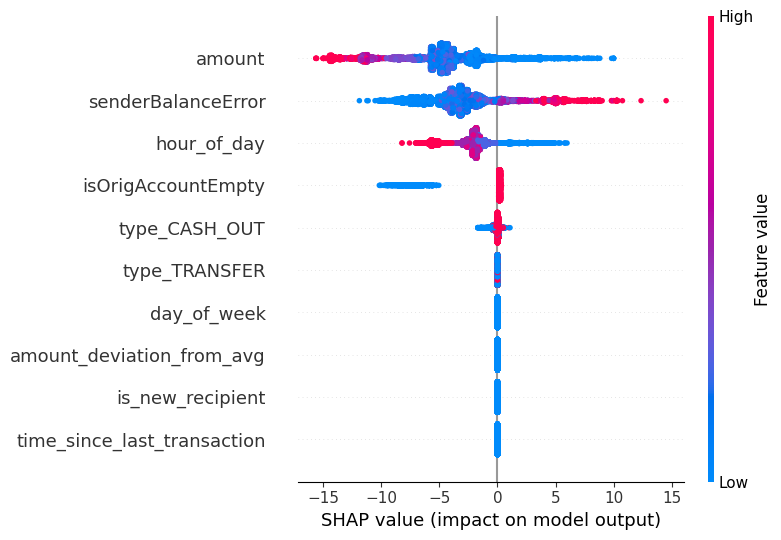

In [ ]:
import shap

# If you haven't installed shap in this session, you might need to run:
# !pip install shap

print("--- Generating SHAP Analysis for the Final Model ---")

# Create the SHAP explainer using our trained final_model
explainer = shap.Explainer(final_model)

# Calculate SHAP values for the test set.
# To make this faster, we can use a sample of the test set.
# Let's use 10,000 samples to get a good representation.
shap_values = explainer(X_test.sample(n=10000, random_state=42))

# Create the summary plot that shows the most important features
print("\nSHAP Summary Plot for the Final, Advanced Model:")
shap.summary_plot(shap_values, X_test.sample(n=10000, random_state=42))

In [ ]:
import joblib

# Define the filename for our final, advanced model
final_model_filename = 'final_fraud_model.joblib'

# Save the trained final_model (our XGBoost model) to the file
joblib.dump(final_model, final_model_filename)

print(f"Final model saved to {final_model_filename}")

Final model saved to final_fraud_model.joblib


SHAP Summary Plot:


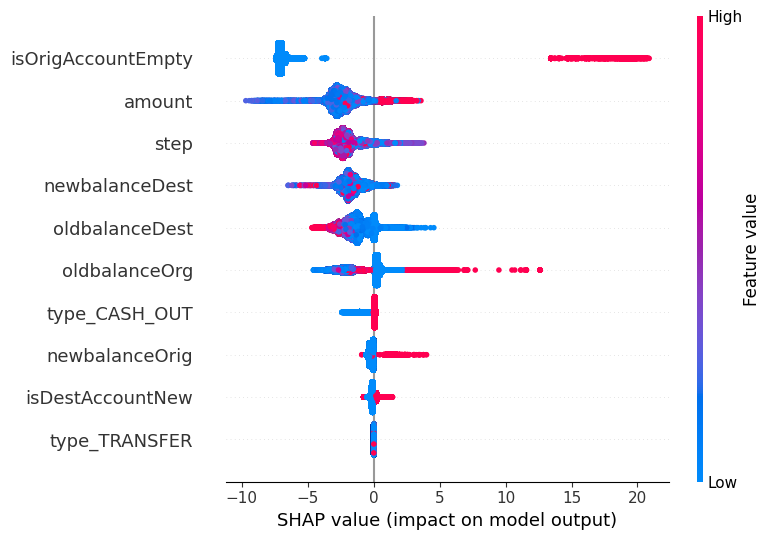

In [ ]:
import shap

# Create the SHAP explainer
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the test set (can take a moment)
shap_values = explainer(X_test)

# Create a summary plot
# This shows the most important features for the model's predictions
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test)

In [ ]:
import joblib

# Define the filename for our model
model_filename = 'fraud_model.joblib'

# Save the trained model to the file
joblib.dump(xgb_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to fraud_model.joblib


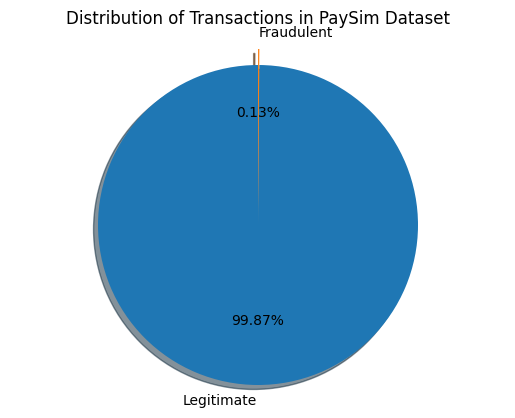

In [ ]:
#imbalance pie chart
import matplotlib.pyplot as plt
labels = 'Legitimate', 'Fraudulent'
sizes = [6354407, 8213]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Distribution of Transactions in PaySim Dataset")
plt.savefig("imbalance_pie_chart.png")
plt.show()

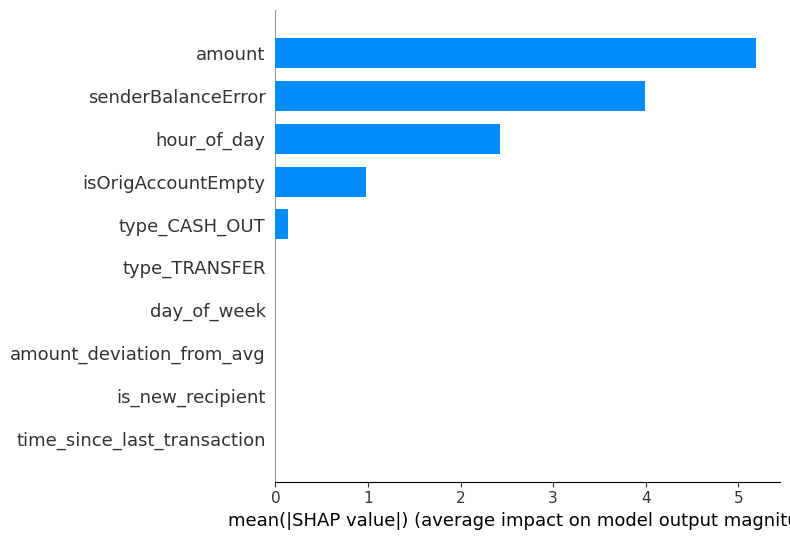

In [ ]:
import shap
# Assuming 'explainer' and 'X_test' are still in memory from the previous step
shap_values = explainer(X_test.sample(n=10000, random_state=42))
shap.summary_plot(shap_values, X_test.sample(n=10000, random_state=42), plot_type="bar")
# You will need to save the plot manually from the Colab output

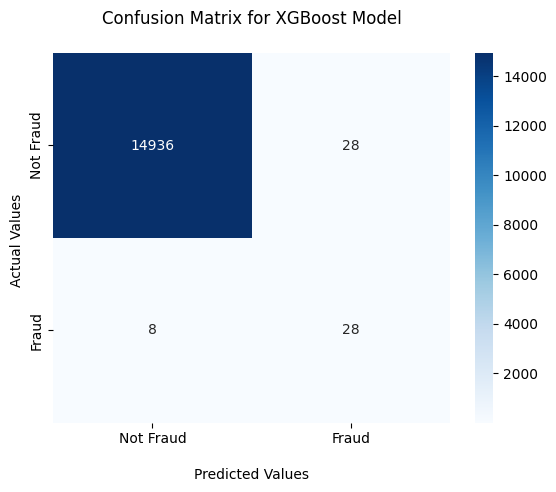

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_final (from XGBoost) are in memory
cm = confusion_matrix(y_test, y_pred_final)
# Our model had very few false negatives, so the numbers will be stark
# TP = cm[1,1], FP = cm[0,1], TN = cm[0,0], FN = cm[1,0]
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix for XGBoost Model\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['Not Fraud','Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud','Fraud'])
plt.savefig("confusion_matrix.png")
plt.show()

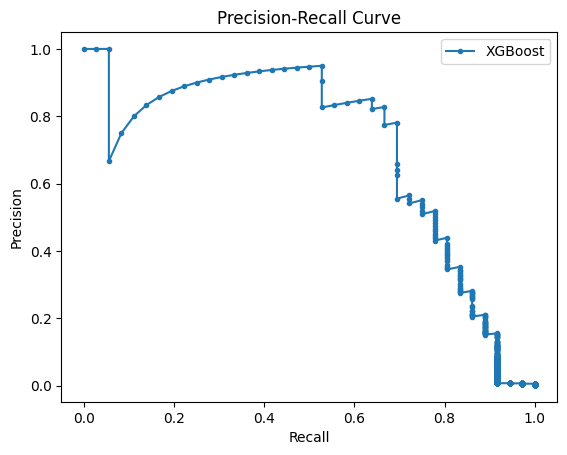

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assuming final_model, X_test, y_test are in memory
y_probs = final_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig("precision_recall_curve.png")
plt.show()

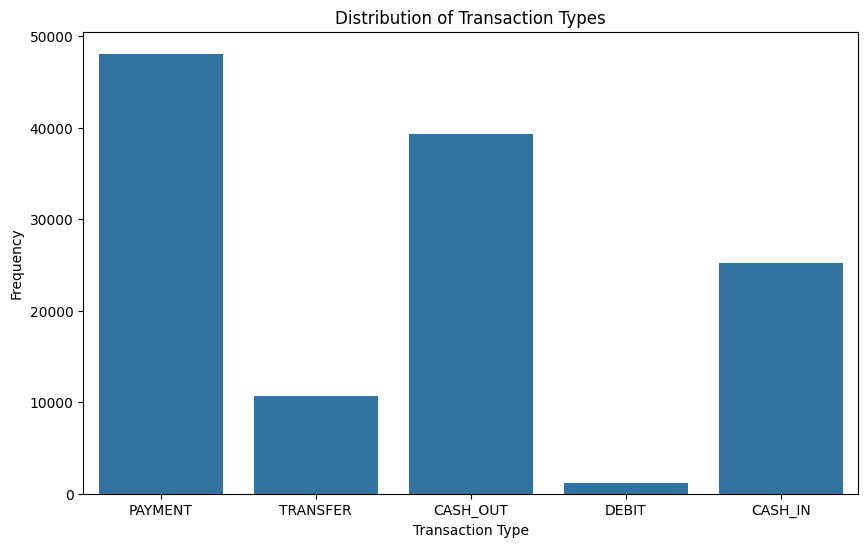

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the original 'df' is still in memory
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.savefig("transaction_types_bar_chart.png")
plt.show()

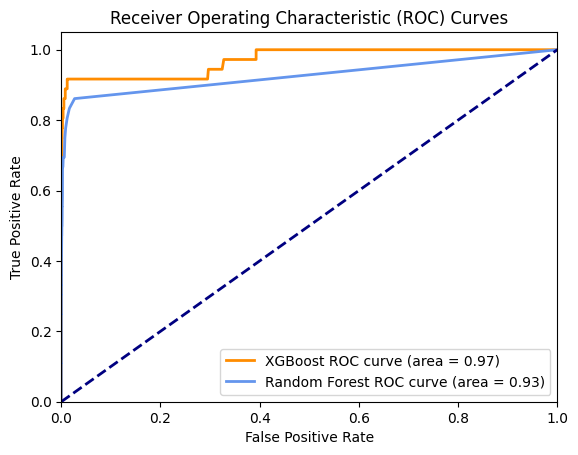

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming final_model, rf_final_model, X_test, y_test are in memory

# Get probabilities for XGBoost
y_probs_xgb = final_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Get probabilities for Random Forest
y_probs_rf = rf_final_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost ROC curve (area = {roc_auc_xgb:0.2f})')
plt.plot(fpr_rf, tpr_rf, color='cornflowerblue', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rf:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig("roc_curves.png")
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest
import joblib

print("--- Training Isolation Forest (The Fast Filter) ---")
# We train the Isolation Forest ONLY on the non-fraudulent data
# so it learns what "normal" behavior is.
# We use the data from our final training set (X_train, y_train)
X_train_normal = X_train[y_train == 0]

# contamination='auto' is a standard setting.
# n_jobs=-1 uses all available CPU cores to speed up training.
iso_forest_model = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)

# Train the model
iso_forest_model.fit(X_train_normal)

# --- Save the Isolation Forest Model ---
iso_forest_filename = 'isolation_forest_model.joblib'
joblib.dump(iso_forest_model, iso_forest_filename)

print(f"Isolation Forest model saved to {iso_forest_filename}")

--- Training Isolation Forest (The Fast Filter) ---
Isolation Forest model saved to isolation_forest_model.joblib
